# Wavelet Packet Decomposition And Tensorflow

## Preprocessing

### Handle datasets

In [1]:
import pyedflib
import os
import numpy as np

MAX_SAMPLE = 19680  # cut the data to algin
NUM_OF_CHANNEL = 5
X = np.array([])
counter = 0
exclude = ["R01", "R02", "R03", "R05", "R07", "R09", "R11", "R13", "R15"]
CURRENT_DIR = os.getcwd()

all_dirs = sorted(os.listdir('MI'))
for dirs in all_dirs:
    for j in sorted(os.listdir(os.path.join('MI', dirs))):
        path = os.path.join(CURRENT_DIR , 'MI', dirs, j)
        if j[4:7] not in exclude:
            with pyedflib.EdfReader(path) as f:
                n = f.signals_in_file
                signal_labels = f.getSignalLabels()
                sigbufs = np.zeros((MAX_SAMPLE, NUM_OF_CHANNEL))
                for i in np.arange(NUM_OF_CHANNEL):
                    sigbufs[:, i] = f.readSignal(i+7)[:MAX_SAMPLE]
                X = np.append(X, sigbufs)
            counter += 1
            if counter >= 6*56:
                break
    if counter >= 6*56:
        break

In [2]:
X = np.array(X)
X = X.reshape(336, -1, 5)
print(f'X shape is {X.shape}, {X.shape[0]} batch, {X.shape[1]} Row, {X.shape[2]} channel')

X shape is (336, 19680, 5), 336 batch, 19680 Row, 5 channel


### Fast Fourier to every window 

#### Bufferworth Lowpass Filter and FFT

In [3]:
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

plt.rcParams.update({'text.color' : "teal",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

In [61]:
WINDOW_FRAME = 256
FILTER_LEVEL = 5
x_test = X[0]
f_s = 512 # sampling frequency
T = 1 / f_s
N = 256
fc = 50 # cut-off frequency
w = fc / (f_s / 2)
labels = ['C3', 'C1', 'Cz', 'C2', 'C4']

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)  # from 0 to 256, 128 data point

def lowPassFilter(data):
    b, a = signal.butter(FILTER_LEVEL, w, 'low', analog=False)
    output = signal.filtfilt(b, a, data)
    return output


def plotfft(feed_y, last):
    fig, axs = plt.subplots(nrows=last, ncols=2, figsize=(18, 4*last))
    holder = []
    for epoch in range(last):
        start = epoch*WINDOW_FRAME
        end   = (epoch+1)*WINDOW_FRAME
        for index, obj in enumerate(labels):
            data = lowPassFilter(feed_y[start:end, index])
            axs[epoch, 0].plot(range(len(data)), data, label=obj)
            yf = np.absolute(np.fft.hfft(data))
            axs[epoch, 1].plot(xf, abs(yf[0:N//2]), label=obj)
            holder.append(yf)
    
        axs[epoch, 0].set_title(f'Datasets {epoch*WINDOW_FRAME} Origin', color='white')
        axs[epoch, 0].legend(loc='upper right')
        axs[epoch, 1].set_title(f'Datasets {epoch*WINDOW_FRAME} FFT', color='white')
        axs[epoch, 1].legend(loc='upper right')
    plt.xlim(0,  WINDOW_FRAME//2)
    plt.xticks(range(0, WINDOW_FRAME//2, 10))
    plt.tight_layout(h_pad=2.0)
    
    return holder

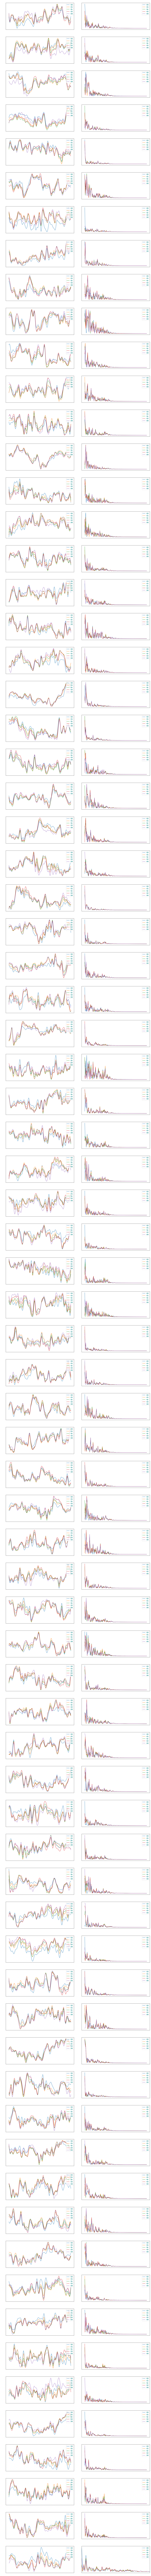

In [62]:
last = MAX_SAMPLE//WINDOW_FRAME
x_train = plotfft(x_test, last)

### Apply Wavelet Packet Transform

In [ ]:
mode = pywt.Modes.smooth

def plot_packets_decomp(data, w, title):
    w = pywt.Wavelet(w)
    a = data
    wp = pywt.WaveletPacket(a, w, mode)
    
    # origin
    plt.subplot(4, 1, 1)
    plt.plot(wp.data)
    
    # level1
    plt.subplot(4, 2, 3)
    plt.plot(wp['a'].data)
    plt.subplot(4, 2, 4)
    plt.plot(wp['d'].data)
    
    # level2
    plt.subplot(4, 4, 9)
    plt.plot(wp['aa'].data)
    plt.subplot(4, 4, 10)
    plt.plot(wp['ad'].data)
    plt.subplot(4, 4, 11)
    plt.plot(wp['da'].data)
    plt.subplot(4, 4, 12)
    plt.plot(wp['dd'].data)
    
    # level3
    plt.subplot(4, 8, 25)
    plt.plot(wp['aaa'].data)
    plt.subplot(4, 8, 26)
    plt.plot(wp['aad'].data)
    plt.subplot(4, 8, 27)
    plt.plot(wp['ada'].data)
    plt.subplot(4, 8, 28)
    plt.plot(wp['add'].data)
    
    plt.subplot(4, 8, 29)
    plt.plot(wp['daa'].data)
    plt.subplot(4, 8, 30)
    plt.plot(wp['dad'].data)
    plt.subplot(4, 8, 31)
    plt.plot(wp['dda'].data)
    plt.subplot(4, 8, 32)
    plt.plot(wp['ddd'].data)
    
    
plot_packets_decomp(y[:,0], 'db4', 'Wavelet Packets' )

## Tensorflow

### Function define

SyntaxError: invalid syntax (tf_util.py, line 656)